In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.nn import functional as F
import timm
import os
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.optim import Adam
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from collections import Counter
import os
import seaborn as sns
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader, ConcatDataset

In [15]:
base=False
large=False
huge=False
Deit_Base=False
swin=True

------------------------------------------------------------------------------------------------------------------------------

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:

# Define class labels
class_labels = {
    "Hatchback": 0,
    "Other": 1,
    "Pickup": 2,
    "Sedan": 3,
    "SUV": 4
}


In [18]:

# Define image size
IMG_SIZE = 224


In [19]:
# Função para analisar as imagens
def analyze_images(image_dir):
    dataset = ImageFolder(image_dir)
    
    # Contar as classes
    class_counts = Counter([item[1] for item in dataset.imgs])
    
    # Tamanho das imagens
    image_sizes = [Image.open(item[0]).size for item in dataset.imgs]
    
    # Tamanho médio das imagens
    avg_width = np.mean([size[0] for size in image_sizes])
    avg_height = np.mean([size[1] for size in image_sizes])
    
    # Exibir resultados
    print(f"Total number of images: {len(dataset)}")
    print(f"Class distribution: {class_counts}")
    print(f"Average image size: {avg_width:.2f} x {avg_height:.2f}")
    
    # Plotar distribuição das classes
    plt.bar(class_counts.keys(), class_counts.values(), tick_label=[dataset.classes[i] for i in class_counts.keys()])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

Total number of images: 4793
Class distribution: Counter({2: 1689, 4: 1222, 3: 680, 0: 602, 1: 600})
Average image size: 375.81 x 291.92


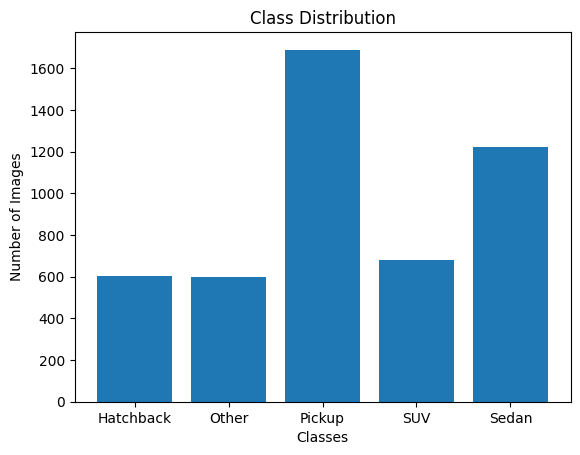

In [20]:
image_dir = './vehicles'  
# Analisar o dataset
analyze_images(image_dir)

In [21]:

# Preprocess images and labels
def preprocess_data(image_dir, class_labels, batch_size=32, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform2 = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2, hue=0.2),
        transforms.ToTensor()
    ])

    transform3 = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=1, scale=(0.05, 0.1), value='random')
    ])

    
    dataset1 = ImageFolder(image_dir, transform=transform)
    dataset2 = ImageFolder(image_dir, transform=transform2)
    dataset3 = ImageFolder(image_dir, transform=transform3)
    train_dataset=ConcatDataset([dataset1, dataset2, dataset3])
    
    # Split dataset into train/test
    train_size = int(0.8 * len(dataset1))
    test_size = len(dataset1) - train_size
    _, test_dataset = random_split(dataset1, [train_size, test_size])
    
    # Create DataLoader for train and test datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [22]:

def generate_embeddings(loader, model, device):
    model.eval()
    embeddings = []
    targets = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            embeddings.append(outputs.cpu())
            targets.append(labels.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    targets = torch.cat(targets, dim=0)
    return embeddings, targets


In [23]:

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [24]:

# Função para treinar o modelo com early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), 'checkpoint.pt')


In [25]:

def evaluate_model(model, test_embeddings, test_targets, device):
    model.eval()
    test_embeddings = test_embeddings.to(device)
    test_targets = test_targets.to(device)
    with torch.no_grad():
        outputs = model(test_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total = test_targets.size(0)
        correct = (predicted == test_targets).sum().item()

        # Cálculo de métricas adicionais
        precision = precision_score(test_targets.cpu(), predicted.cpu(), average='macro')
        recall = recall_score(test_targets.cpu(), predicted.cpu(), average='macro')
        f1 = f1_score(test_targets.cpu(), predicted.cpu(), average='macro')
        conf_matrix = confusion_matrix(test_targets.cpu(), predicted.cpu())

        

    accuracy = 100 * correct / total
    return accuracy, precision, recall, f1, conf_matrix


In [26]:
# Criar o modelo ViT pré-treinado

if(base):
    vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
if(large):
    vit_model = timm.create_model('vit_large_patch16_224', pretrained=True)
if(huge):
    vit_model = timm.create_model('vit_huge_patch14_224', pretrained=True)
if(Deit_Base):
    vit_model = timm.create_model('deit_base_patch16_224', pretrained=True)
if(swin):
    vit_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)




vit_model = vit_model.to(device)


RuntimeError: Unknown model (t2t_vit_24)

In [ ]:
train_loader, test_loader=train_loader, test_loader = preprocess_data(image_dir, class_labels, batch_size=16)


train_embeddings, train_targets = generate_embeddings(train_loader, vit_model, device)
test_embeddings, test_targets = generate_embeddings(test_loader, vit_model, device)

# Dimensões de entrada e saída
input_dim = train_embeddings.shape[1]
output_dim = len(class_labels)
hidden_dim = 512  # Dimensão da camada oculta (ajuste conforme necessário)

In [ ]:

# Crie o modelo
mlp = MLP(input_dim, hidden_dim, output_dim).to(device)


In [ ]:

# Função de Loss, Otimizador e epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)



In [ ]:

# Inicializar listas para monitorar perda e acurácia
train_loss = []
valid_loss = []


In [ ]:
def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:

num_epochs = 10000
patience = 5  # Paciencia para early stopping
early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

for epoch in range(num_epochs):
    mlp.train()
    train_embeddings = train_embeddings.to(device)
    train_targets = train_targets.to(device)

    # Forward pass
    outputs = mlp(train_embeddings)
    loss = criterion(outputs, train_targets)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save training loss
    train_loss.append(loss.item())

    # Validation
    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(train_embeddings)
        val_loss = criterion(val_outputs, train_targets)
        valid_loss.append(val_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    early_stopping(val_loss, mlp)
    if early_stopping.early_stop:
        print("Early stopping")
        break


Epoch [1/10000], Loss: 1.6217, Val Loss: 1.4048
Epoch [2/10000], Loss: 1.4048, Val Loss: 1.2491
Epoch [3/10000], Loss: 1.2491, Val Loss: 1.0518
Epoch [4/10000], Loss: 1.0518, Val Loss: 0.8649
Epoch [5/10000], Loss: 0.8649, Val Loss: 0.7155
Epoch [6/10000], Loss: 0.7155, Val Loss: 0.6183
Epoch [7/10000], Loss: 0.6183, Val Loss: 0.5830
Epoch [8/10000], Loss: 0.5830, Val Loss: 0.5610
Epoch [9/10000], Loss: 0.5610, Val Loss: 0.4916
Epoch [10/10000], Loss: 0.4916, Val Loss: 0.4967
Epoch [11/10000], Loss: 0.4967, Val Loss: 0.4489
Epoch [12/10000], Loss: 0.4489, Val Loss: 0.4449
Epoch [13/10000], Loss: 0.4449, Val Loss: 0.4135
Epoch [14/10000], Loss: 0.4135, Val Loss: 0.4133
Epoch [15/10000], Loss: 0.4133, Val Loss: 0.3898
Epoch [16/10000], Loss: 0.3898, Val Loss: 0.3714
Epoch [17/10000], Loss: 0.3714, Val Loss: 0.3724
Epoch [18/10000], Loss: 0.3724, Val Loss: 0.3419
Epoch [19/10000], Loss: 0.3419, Val Loss: 0.3432
Epoch [20/10000], Loss: 0.3432, Val Loss: 0.3172
Epoch [21/10000], Loss: 0.317

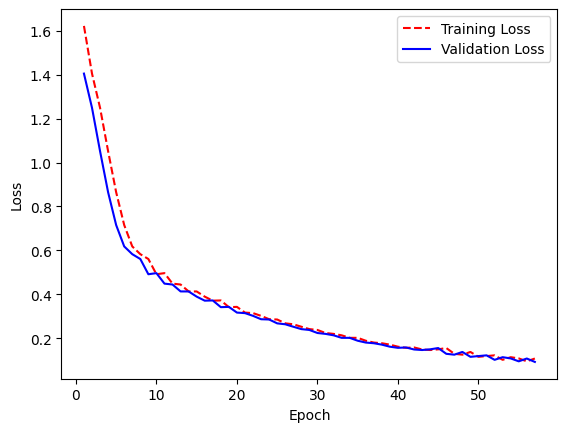

In [ ]:

# Visualizar histórico de perda
epoch_count = range(1, len(train_loss) + 1)
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:

# Carregar o melhor modelo salvo durante o early stopping
mlp.load_state_dict(torch.load('checkpoint.pt'))


<All keys matched successfully>

Avaliação após o treinamento:
Final Test Accuracy: 99.58 %
Final Precision: 1.00
Final Recall: 0.99
Final F1 Score: 0.99
Final Confusion Matrix:
[[134   0   0   1   1]
 [  0 114   0   0   0]
 [  0   0 337   1   0]
 [  0   0   0 115   1]
 [  0   0   0   0 255]]


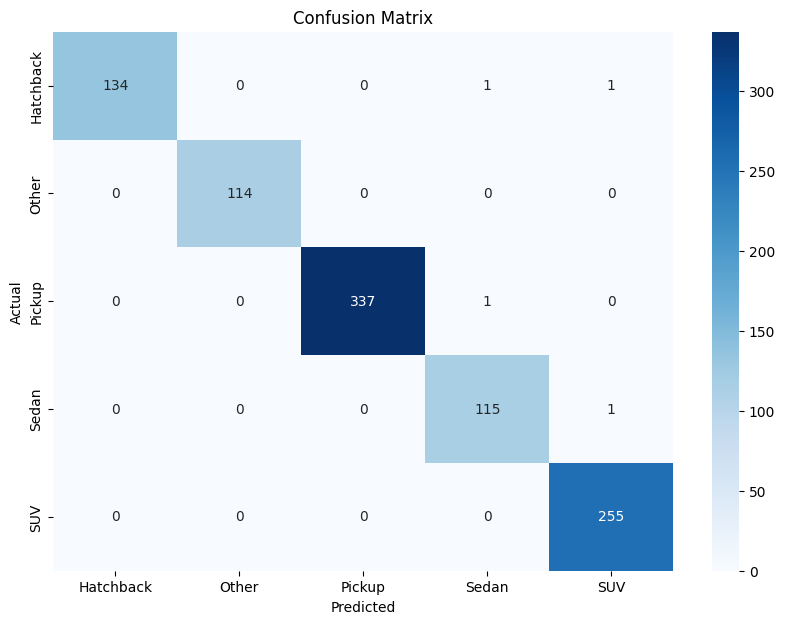

In [ ]:
print("Avaliação após o treinamento:")
final_accuracy, final_precision, final_recall, final_f1, final_conf_matrix = evaluate_model(mlp, test_embeddings, test_targets, device)
print(f'Final Test Accuracy: {final_accuracy:.2f} %')
print(f'Final Precision: {final_precision:.2f}')
print(f'Final Recall: {final_recall:.2f}')
print(f'Final F1 Score: {final_f1:.2f}')
print(f'Final Confusion Matrix:\n{final_conf_matrix}')

# Plotar a matriz de confusão
plot_confusion_matrix(final_conf_matrix, list(class_labels.keys()))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total images loaded: 959
Incorrect indices: [316, 418, 676, 691]
True labels: [0, 0, 2, 3]
Predicted labels: [3, 4, 3, 4]

Número de imagens incorretamente classificadas: 4



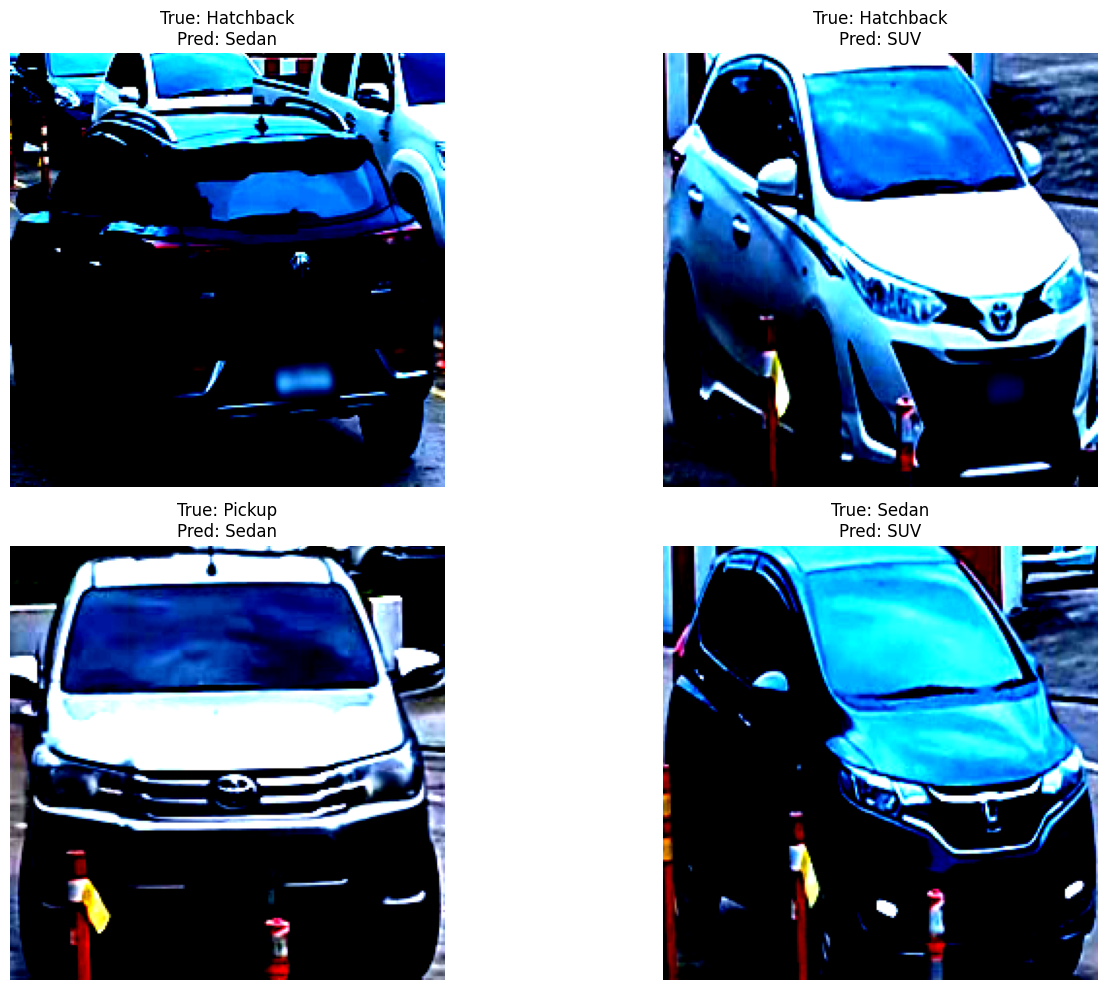

In [ ]:
# Identificar amostras incorretamente classificadas
incorrect_indices = []
true_labels = []
pred_labels = []
class_labels_inv = {v: k for k, v in class_labels.items()}

mlp.eval()
with torch.no_grad():
    for i, (embedding, target) in enumerate(zip(test_embeddings, test_targets)):
        output = mlp(embedding.unsqueeze(0).to(device))
        predicted = torch.argmax(output, dim=1).item()
        true_label = target.item()
        if predicted != true_label:
            incorrect_indices.append(i)
            true_labels.append(true_label)
            pred_labels.append(predicted)

# Carregar todas as imagens de test_loader em uma lista
test_images = []
test_targets_list = []
for images, targets in test_loader:
    test_images.extend(images)
    test_targets_list.extend(targets)

# Verificação de dados
print(f"Total images loaded: {len(test_images)}")
print(f"Incorrect indices: {incorrect_indices}")
print(f"True labels: {true_labels}")
print(f"Predicted labels: {pred_labels}")

# Mostrar imagens incorretamente classificadas
num_incorrect = len(incorrect_indices)
print(f'\nNúmero de imagens incorretamente classificadas: {num_incorrect}\n')

# Ajustar o número de colunas para ter no máximo 2 colunas
num_cols = 2
num_rows = (num_incorrect + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for ax, idx, true_label, pred_label in zip(axes, incorrect_indices, true_labels, pred_labels):
    ax.imshow(test_images[idx].cpu().permute(1, 2, 0))  # Acessa a imagem pelo índice
    true_class = class_labels.get(true_label, f'{true_label}')
    pred_class = class_labels.get(pred_label, f'{pred_label}')
    
    true_class2 = class_labels_inv.get(true_label, f'Unknown({true_label})')
    pred_class2 = class_labels_inv.get(pred_label, f'Unknown({pred_label})')

    ax.set_title(f'True: {true_class2}\nPred: {pred_class2}')
    ax.axis('off')

# Desativar eixos vazios
for i in range(num_incorrect, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Teste